# Introduction

The followig aims to get you up and running with the predict. Make a copy of the notebook and run all cells. We will also show you how to get your submission file from kaggle. 

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [11]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor,KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [12]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

In [21]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [23]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


## EDA
Discovery phase and data understanding

In [24]:
#confirming the data shapes of the datasets
df_train.shape , df_test.shape ,df_movies.shape,df_imdb.shape,df_links.shape

((10000038, 4), (5000019, 2), (62423, 3), (27278, 6), (62423, 3))

Datatypes

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [27]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [28]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [29]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


Checking for nulls

In [30]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [31]:
df_imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [32]:
df_tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

DATA COMBINATION

In [33]:
combined_m=pd.merge(df_movies,df_train,how='left',on='movieId')

In [34]:
combined_m.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,158849.0,5.0,9.947168e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,97203.0,5.0,9.426832e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,161871.0,3.0,8.331046e+08
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,45117.0,4.0,1.442257e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27431.0,5.0,8.496678e+08


In [ ]:
#Plot showing the distribution of movies
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x='rating',y='title',data=combined_m,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')
    
plt.show()

**Most common Genres**

In [35]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


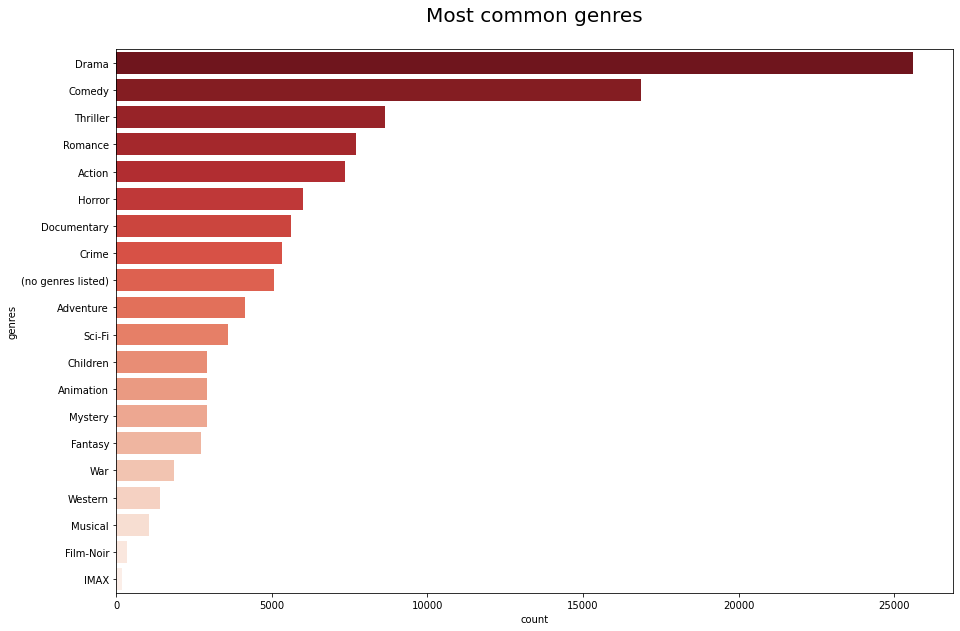

In [37]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

* Top 5 Movie genres: Drama, Comedy, Thriller,Romance and Action.
* Bottom 5 Movie genres: IMAX,Film-Noir,Musical,Western and War.

DISTRIBUTION OF RATINGS

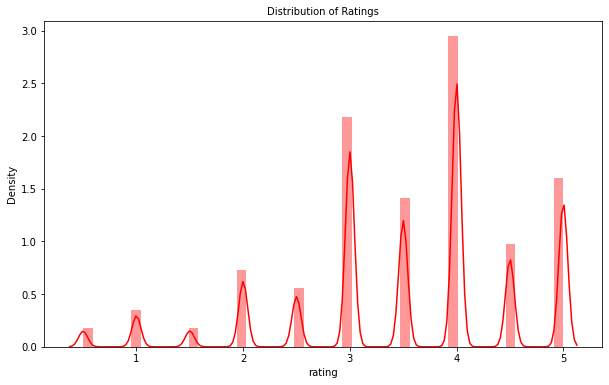

In [38]:
plt.figure(figsize = (10,6))
axes=sns.distplot(df_train['rating'],color='red')
axes.set_title('Distribution of Ratings',fontsize=10)
plt.show()

POPULAR ACTORS(TOP 5)

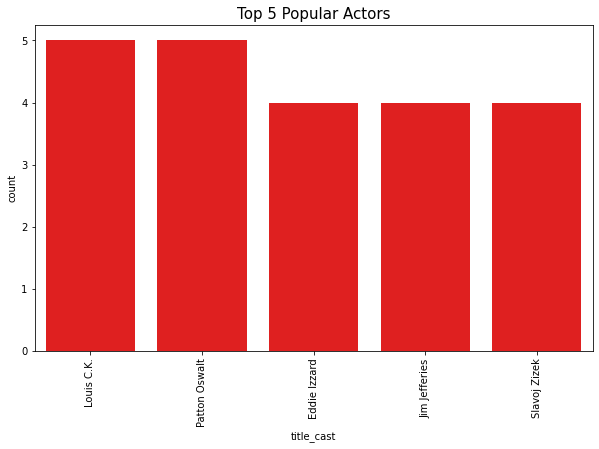

In [39]:
plt.figure(figsize = (10,6))
title_cast=df_imdb['title_cast'].explode()
ax=sns.countplot(x=title_cast, order = title_cast.value_counts().index[:5],color='red')
ax.set_title('Top 5 Popular Actors',fontsize=15)
plt.xticks(rotation=90)
plt.show()

POPULAR MOVIE DIRECTORS(TOP 10)

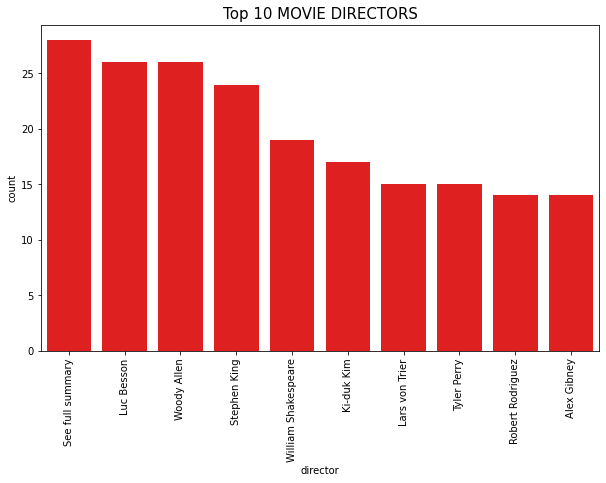

In [40]:
plt.figure(figsize = (10,6))
director=df_imdb['director'].explode()
ax=sns.countplot(x=director, order = director.value_counts().index[:10],color='red')
ax.set_title('Top 10 MOVIE DIRECTORS',fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Data Prepartion

In [ ]:
## Here you will sort your data out and process it accordingly

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



COLLABATIVE FILTERING

SVD

In [13]:
reader = Reader()
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)
df_train.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [14]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the dataset (download it if needed)
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8345  0.8334  0.8342  0.8340  0.8343  0.8341  0.0004  
MAE (testset)     0.6339  0.6325  0.6332  0.6334  0.6333  0.6332  0.0005  
FCP (testset)     0.6918  0.6930  0.6921  0.6912  0.6914  0.6919  0.0006  
Fit time          883.44  893.88  896.47  886.66  888.71  889.83  4.75    
Test time         54.70   52.19   49.70   50.39   51.72   51.74   1.73    


{'test_rmse': array([0.8344588 , 0.83340483, 0.83415472, 0.83398428, 0.83426757]),
 'test_mae': array([0.63386344, 0.63246153, 0.63320189, 0.63340347, 0.63330557]),
 'test_fcp': array([0.6918082 , 0.69302154, 0.69213276, 0.69123337, 0.69143723]),
 'fit_time': (883.4358739852905,
  893.880711555481,
  896.469973564148,
  886.6592955589294,
  888.7136127948761),
 'test_time': (54.69723153114319,
  52.19340252876282,
  49.695385456085205,
  50.39262652397156,
  51.717206954956055)}

In [17]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [19]:
df_train[df_train['userId'] == 1]

,userId,movieId,rating,timestamp
197184,1,6954,3.5,1147869150
718844,1,1217,3.5,1147878326
724395,1,7323,3.5,1147869119
1497122,1,2632,5.0,1147878248
1946297,1,1250,4.0,1147868414
2000832,1,6370,4.5,1147869191
2072860,1,8685,1.0,1147878023
2313219,1,7937,3.0,1147878055
2524478,1,4308,3.0,1147868534
2533005,1,665,5.0,1147878820


In [20]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.9924046226145844, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 3.992. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

Evaluating the RMSE,MAE and FCP of algorithm NMF

In [42]:
# Apply your modelling here
from surprise import Dataset
from surprise.model_selection import cross_validate

benchmark=[]
for algorithm in [NMF()]:
    results=cross_validate(algorithm, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=True)
    
    tmp=pd.DataFrame.from_dict(results).mean(axis=0)
    tmp=tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Evaluating RMSE, MAE, FCP of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8822  0.8834  0.8832  0.8833  0.8840  0.8832  0.0006  
MAE (testset)     0.6727  0.6733  0.6738  0.6734  0.6743  0.6735  0.0005  
FCP (testset)     0.6666  0.6661  0.6657  0.6678  0.6658  0.6664  0.0008  
Fit time          981.10  991.56  979.33  998.47  979.77  986.05  7.66    
Test time         59.04   63.82   55.07   59.02   45.99   56.59   5.98    


,test_rmse,test_mae,test_fcp,fit_time,test_time
Algorithm,,,,,
NMF,0.883217,0.673514,0.666401,986.04558,56.589517


Evaluating the RMSE,MAE and FCP of algorithms


In [ ]:
benchmark=[]
for algorithm in [SVDpp(), SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    results=cross_validate(algorithm, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=True)
    
    tmp=pd.DataFrame.from_dict(results).mean(axis=0)
    tmp=tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [ ]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [ ]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

In [ ]:
df.to_csv('my_test_output.csv', index = False)